In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scipy.stats import ttest_ind_from_stats
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def calcHistogramDistance(dist1, dist2):
    t=np.sqrt(dist1*dist2).sum()
    #t=t[t!=0]
    if t==0:
        return -1
    else:
        d=np.log(t)*-1
        return d

In [3]:
def getDisposedLoyalty(row):
    #If Disposed and Purchased vehicle are not the same brand, mark as not conquest. If same, Loyal.
    if row['New Model Purchased - Brand'] == row['Brand (Disposed)']:
        return 'Disposed Loyal'
    elif row['Brand (Disposed)'] == 'Did Not Own':
        return 'First Purchase'
    elif row['Brand (Disposed)'] == 'Did Not Dispose':
        return 'Did Not Dispose'
    else:
        return 'Disposed Conquest'

In [4]:
def getFleetLoyalty(row):
    if len(row['fleetSet'])==0:
        return 'Empty Fleet'
    elif row['New Model Purchased - Brand'] in row['fleetSet']:
        return 'Fleet Loyal'
    else:
        return 'Fleet Conquest'

In [5]:
def getShoppedSet(row):
    #create set of shopped vehicles, add to shoppedCountDict count
    shoppedVars = ['New Model Purchased - Brand','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (1)','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (2)','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (3)']
    shoppedSet = [row[j] for j in shoppedVars if row[j] not in [' ', 'No Other Make Considered']]
    shoppedSet = frozenset(shoppedSet)
    return shoppedSet

In [6]:
def getFleetSet(row):
    #create set of owned vehicles, add to ownedCountDict count
    fleetVars = ['Total Brand In Household Fleet (Mk) (2)','Total Brand In Household Fleet (Mk) (3)','Total Brand In Household Fleet (Mk) (4)']
    fleetSet = [row[j] for j in fleetVars if row[j] not in [' ', 'No Other Vehicle Owned', 'Did Not Own']]
    fleetSet = frozenset(fleetSet)
    return fleetSet

In [7]:
def shoppedOwnedComparison(row):
    shoppedVars = ['New Model Purchased - Brand','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (1)','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (2)','Brands Seriously Considered (Most Serious, 2nd,3rd Choice) (3)']
    shoppedSet = frozenset([row[j] for j in shoppedVars if row[j] not in [' ', 'No Other Make Considered']])
    ownedVars = ['Brand (Disposed)','Total Brand In Household Fleet (Mk) (2)','Total Brand In Household Fleet (Mk) (3)','Total Brand In Household Fleet (Mk) (4)']
    ownedSet = frozenset([row[j] for j in ownedVars if row[j] not in [' ', 'No Other Vehicle Owned', 'Did Not Own']])
    
    if len(ownedSet)==0:
        return 'First Owned'
    if shoppedSet <= ownedSet:
        return 'Only Shopped Previously Owned'
    elif len(shoppedSet&ownedSet)>0:
        return 'Shopped Mix of Owned and New'
    else:
        return 'Only Shopped New'

In [8]:
def shoppedPurchase(row):
    if len(row['shoppedSet']) > 1:
        return 'Shopped Multiple Brands'
    else:
        return 'Only Shopped Purchase Brands'

In [9]:
def disposedLoyalConquestOther(row):
    if row['Brand (Disposed)'] == row['New Model Purchased - Brand']:
        return 'Disposed Loyal'
    elif row['Brand (Disposed)'] == 'Did Not Dispose':
        return 'Not Disposed'
    else:
        return 'Disposed Conquest'

In [10]:
def fleetLoyalConquestOther(row):
    if len(row['fleetSet']) == 0:
        return'Empty Fleet'
    elif row['New Model Purchased - Brand'] in row['fleetSet']:
        return 'Fleet Loyal'
    else:
        return 'Fleet Conquest'

In [11]:
#f = open(r'D:\LocalData\peterk2\Desktop\SV 2016 data.csv', encoding ='utf-8')
df = pd.read_csv(r'D:\LocalData\peterk2\Desktop\Strat Vis Shopping Analysis\SV 2016 data for Analysis model plus loyalty weights.csv',encoding = 'ISO-8859-1', dtype=str).fillna(' ')

In [12]:
df['shoppedSet'] = df.apply(getShoppedSet, axis=1)
df['fleetSet'] = df.apply(getFleetSet, axis=1)
df['Disposed Loyal Conquest Other'] = df.apply(getDisposedLoyalty, axis=1)
df['Fleet Loyal Conquest Other'] = df.apply(getFleetLoyalty, axis=1)
df['OnlyShoppedPurchase'] = df.apply(shoppedPurchase, axis=1)
df['Shop Owned Comparison'] = df.apply(shoppedOwnedComparison, axis=1)

In [13]:
df['Sales Weighting'] = df['Sales Weighting'].apply(pd.to_numeric)

In [14]:
df['Concatenated Groups'] = df['Disposed Loyal Conquest Other']+df['Fleet Loyal Conquest Other']+df['OnlyShoppedPurchase']+df['Shop Owned Comparison']

In [15]:
a = df.groupby(['Concatenated Groups','New Model Purchased - Brand'])['Sales Weighting'].sum().unstack().fillna(0.0)

In [16]:
a/a.sum()

New Model Purchased - Brand,Buick,Chevrolet,Chrysler,Dodge,Fiat,Ford,GMC,Honda,Hyundai,Jeep,Kia,Mazda,Mercedes-Benz,Mitsubishi,Nissan,Ram,Subaru,Toyota,Volkswagen
Concatenated Groups,,,,,,,,,,,,,,,,,,,
Did Not DisposeEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,0.002456,0.004213,0.000000,0.005844,0.000000,0.004760,0.000869,0.000000,0.000000,0.001234,0.002373,0.000882,0.000000,0.005385,0.000000,0.001583,0.000993,0.002000,0.002051
Did Not DisposeEmpty FleetShopped Multiple BrandsOnly Shopped New,0.001834,0.001259,0.005240,0.001831,0.000000,0.000513,0.000624,0.000000,0.001913,0.000753,0.001334,0.002433,0.000000,0.000000,0.000049,0.000000,0.000941,0.000391,0.000000
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,0.022602,0.019577,0.043836,0.054523,0.057521,0.013942,0.029438,0.017151,0.020137,0.054391,0.031219,0.021386,0.021714,0.025172,0.026397,0.020981,0.022056,0.020515,0.040233
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New,0.024961,0.017078,0.048118,0.047924,0.094939,0.015666,0.030543,0.023834,0.032327,0.022575,0.031145,0.046399,0.086857,0.050243,0.034069,0.024413,0.027116,0.018608,0.054618
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,0.019862,0.009011,0.026200,0.023911,0.067053,0.009820,0.018141,0.015353,0.014695,0.016439,0.019079,0.035578,0.000000,0.033878,0.020863,0.027978,0.020619,0.010407,0.022650
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned,0.007917,0.037224,0.000000,0.023652,0.011320,0.030297,0.020654,0.040830,0.021614,0.014813,0.019069,0.005133,0.065143,0.009933,0.016429,0.019796,0.009865,0.030729,0.020877
Did Not DisposeFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned,0.001230,0.003336,0.009409,0.002181,0.004363,0.003989,0.004227,0.005881,0.005043,0.001038,0.001334,0.002990,0.000000,0.002794,0.003007,0.000000,0.001744,0.004238,0.002286
Did Not DisposeFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New,0.006961,0.019233,0.015720,0.022721,0.005247,0.021557,0.005689,0.030538,0.020257,0.018491,0.009649,0.013884,0.021714,0.016885,0.014940,0.017815,0.005590,0.024581,0.032023
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,0.047321,0.023554,0.079558,0.054680,0.018335,0.019921,0.024824,0.019128,0.040944,0.046564,0.040476,0.024548,0.021714,0.027929,0.034169,0.023750,0.026931,0.021079,0.039057


In [17]:
b = df.groupby('Concatenated Groups')['Sales Weighting'].sum()#.unstack().fillna(0.0)
(b/b.sum()).sort_values()

Concatenated Groups
First PurchaseFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned            0.000145
Did Not DisposeEmpty FleetShopped Multiple BrandsOnly Shopped New                        0.000726
First PurchaseFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New          0.001851
Did Not DisposeEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New                   0.002077
First PurchaseFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New             0.002193
Did Not DisposeFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned           0.003456
Disposed LoyalFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned            0.003981
First PurchaseFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned       0.004413
First PurchaseFleet ConquestShopped Multiple BrandsOnly Shopped New                      0.005140
First PurchaseFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New                 0.005536


In [18]:
dropList = ['First PurchaseFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned','Did Not DisposeEmpty FleetShopped Multiple BrandsOnly Shopped New','Disposed LoyalFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned','Did Not DisposeEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New','First PurchaseFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New','First PurchaseFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New','Did Not DisposeFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned','First PurchaseFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned','First PurchaseFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New','First PurchaseFleet ConquestShopped Multiple BrandsOnly Shopped New','First PurchaseEmpty FleetShopped Multiple BrandsFirst Owned','Disposed LoyalFleet ConquestShopped Multiple BrandsOnly Shopped Previously Owned','First PurchaseEmpty FleetOnly Shopped Purchase BrandsFirst Owned']
dfWorking = df[~df['Concatenated Groups'].isin(dropList)]

In [19]:
a = dfWorking.groupby(['Concatenated Groups','New Model Purchased - Brand'])['Sales Weighting'].sum().unstack().fillna(0.0)
catByBrand = a/a.sum()

In [20]:
catByBrand

New Model Purchased - Brand,Buick,Chevrolet,Chrysler,Dodge,Fiat,Ford,GMC,Honda,Hyundai,Jeep,Kia,Mazda,Mercedes-Benz,Mitsubishi,Nissan,Ram,Subaru,Toyota,Volkswagen
Concatenated Groups,,,,,,,,,,,,,,,,,,,
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,0.023978,0.020496,0.048436,0.059013,0.060882,0.014614,0.031353,0.018742,0.021855,0.057518,0.032968,0.023273,0.022292,0.026533,0.028191,0.022072,0.023112,0.021803,0.044853
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New,0.026480,0.017880,0.053168,0.051870,0.100486,0.016421,0.032529,0.026046,0.035085,0.023872,0.032889,0.050492,0.089167,0.052958,0.036384,0.025682,0.028414,0.019776,0.060890
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,0.021071,0.009435,0.028949,0.025880,0.070970,0.010293,0.019320,0.016777,0.015949,0.017384,0.020148,0.038717,0.000000,0.035709,0.022281,0.029432,0.021606,0.011060,0.025252
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned,0.008399,0.038973,0.000000,0.025599,0.011981,0.031756,0.021997,0.044619,0.023458,0.015665,0.020137,0.005586,0.066875,0.010470,0.017546,0.020825,0.010338,0.032658,0.023275
Did Not DisposeFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New,0.007385,0.020136,0.017370,0.024592,0.005553,0.022595,0.006059,0.033372,0.021986,0.019554,0.010190,0.015109,0.022292,0.017797,0.015955,0.018740,0.005858,0.026125,0.035701
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,0.050201,0.024660,0.087907,0.059183,0.019406,0.020881,0.026439,0.020903,0.044437,0.049241,0.042743,0.026714,0.022292,0.029439,0.036491,0.024984,0.028220,0.022403,0.043543
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New,0.030755,0.014266,0.072779,0.037360,0.030389,0.017622,0.021428,0.020600,0.034328,0.034464,0.036238,0.050168,0.000000,0.062203,0.030931,0.015270,0.021313,0.019469,0.053252
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New,0.025965,0.009192,0.027767,0.012171,0.011981,0.011069,0.012334,0.010903,0.018608,0.017374,0.013052,0.021606,0.000000,0.016063,0.012666,0.010133,0.012668,0.010655,0.021573
Disposed ConquestFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,0.104508,0.046368,0.169900,0.153018,0.213744,0.034162,0.103774,0.029547,0.052974,0.115096,0.061795,0.041999,0.022292,0.076751,0.051262,0.111884,0.062562,0.034039,0.062225


In [21]:
b = dfWorking.groupby('Concatenated Groups')['Sales Weighting'].sum()#.unstack().fillna(0.0)
catOverall = b/b.sum()

In [22]:
pd.concat([catOverall.to_frame(),catByBrand], axis=1)

,Sales Weighting,Buick,Chevrolet,Chrysler,Dodge,Fiat,Ford,GMC,Honda,Hyundai,Jeep,Kia,Mazda,Mercedes-Benz,Mitsubishi,Nissan,Ram,Subaru,Toyota,Volkswagen
Concatenated Groups,,,,,,,,,,,,,,,,,,,,
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,0.025733,0.023978,0.020496,0.048436,0.059013,0.060882,0.014614,0.031353,0.018742,0.021855,0.057518,0.032968,0.023273,0.022292,0.026533,0.028191,0.022072,0.023112,0.021803,0.044853
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New,0.026879,0.026480,0.017880,0.053168,0.051870,0.100486,0.016421,0.032529,0.026046,0.035085,0.023872,0.032889,0.050492,0.089167,0.052958,0.036384,0.025682,0.028414,0.019776,0.060890
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,0.016730,0.021071,0.009435,0.028949,0.025880,0.070970,0.010293,0.019320,0.016777,0.015949,0.017384,0.020148,0.038717,0.000000,0.035709,0.022281,0.029432,0.021606,0.011060,0.025252
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned,0.027493,0.008399,0.038973,0.000000,0.025599,0.011981,0.031756,0.021997,0.044619,0.023458,0.015665,0.020137,0.005586,0.066875,0.010470,0.017546,0.020825,0.010338,0.032658,0.023275
Did Not DisposeFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New,0.020761,0.007385,0.020136,0.017370,0.024592,0.005553,0.022595,0.006059,0.033372,0.021986,0.019554,0.010190,0.015109,0.022292,0.017797,0.015955,0.018740,0.005858,0.026125,0.035701
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,0.030023,0.050201,0.024660,0.087907,0.059183,0.019406,0.020881,0.026439,0.020903,0.044437,0.049241,0.042743,0.026714,0.022292,0.029439,0.036491,0.024984,0.028220,0.022403,0.043543
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New,0.024777,0.030755,0.014266,0.072779,0.037360,0.030389,0.017622,0.021428,0.020600,0.034328,0.034464,0.036238,0.050168,0.000000,0.062203,0.030931,0.015270,0.021313,0.019469,0.053252
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New,0.012706,0.025965,0.009192,0.027767,0.012171,0.011981,0.011069,0.012334,0.010903,0.018608,0.017374,0.013052,0.021606,0.000000,0.016063,0.012666,0.010133,0.012668,0.010655,0.021573
Disposed ConquestFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,0.056774,0.104508,0.046368,0.169900,0.153018,0.213744,0.034162,0.103774,0.029547,0.052974,0.115096,0.061795,0.041999,0.022292,0.076751,0.051262,0.111884,0.062562,0.034039,0.062225


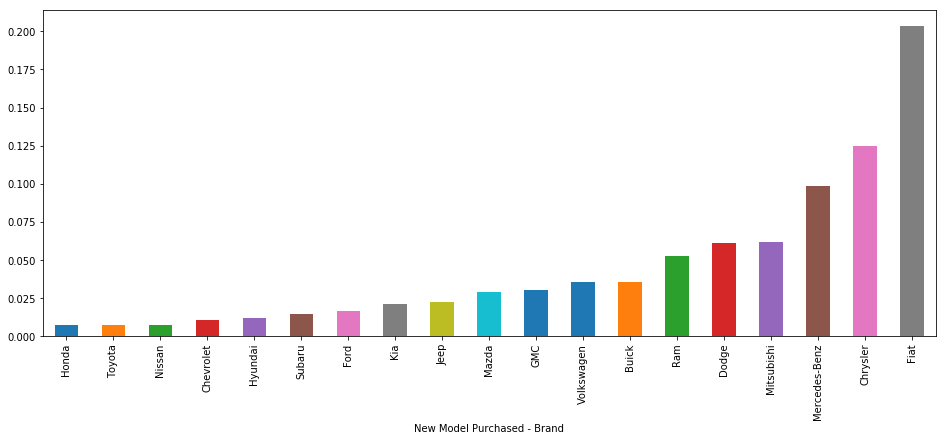

In [23]:
(-1*np.log(np.sqrt(catByBrand.multiply(catOverall, axis='index')).sum())).sort_values().plot(kind='bar',figsize=(16,6))

In [24]:
a = dfWorking.groupby(['Concatenated Groups','Age Bucket'])['Sales Weighting'].sum().unstack().fillna(0.0)
catByAge = a/a.sum()

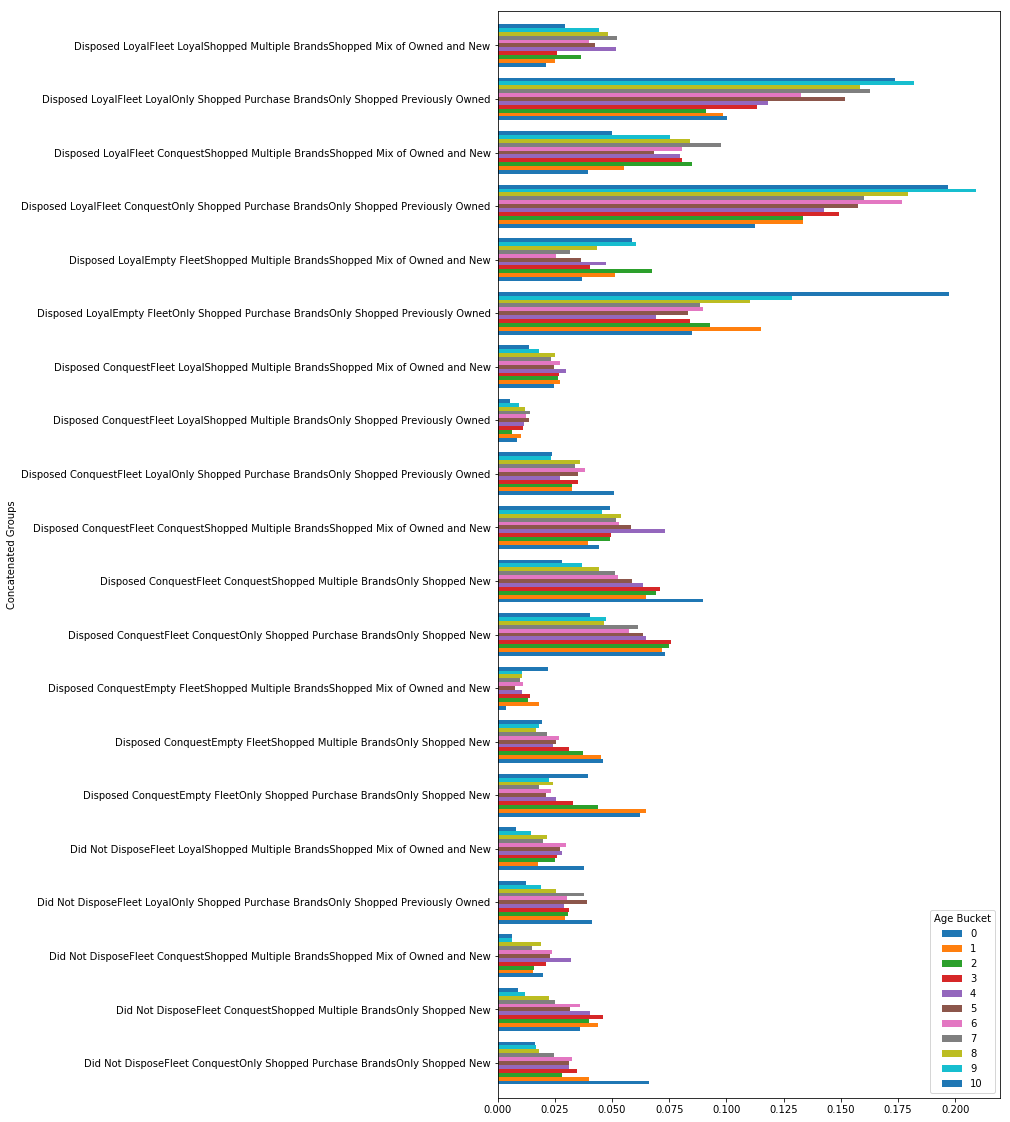

In [25]:
cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
catByAge = catByAge[cols]
catByAge[cols].plot(kind='barh', figsize=(9,20), width=0.8)

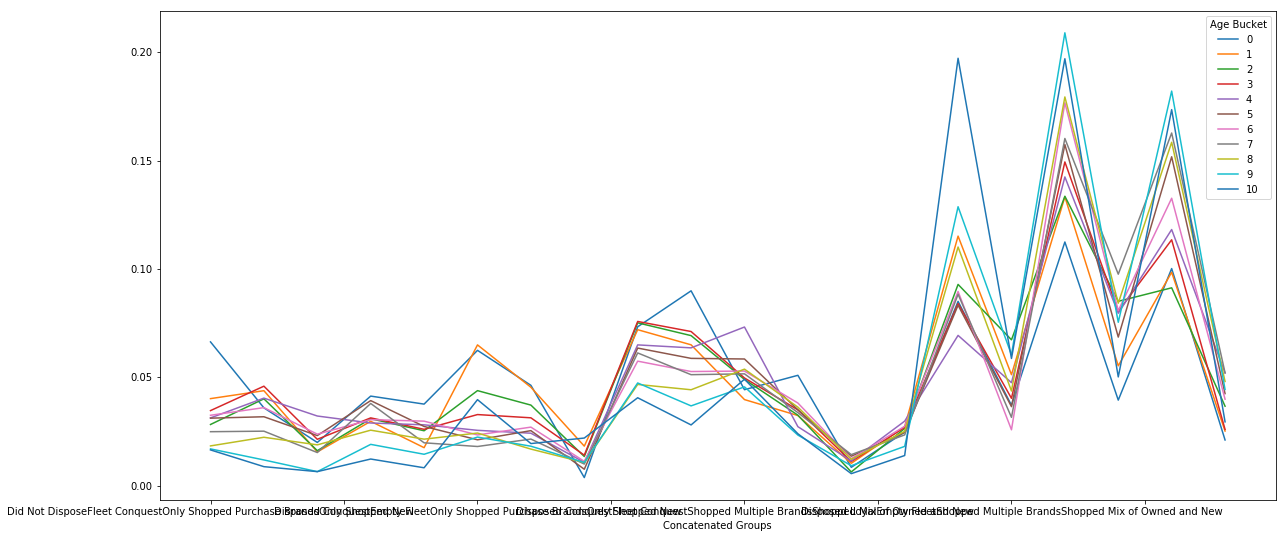

In [26]:
cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
catByAge = catByAge[cols]
catByAge[cols].plot(kind='line', figsize=(20,9))

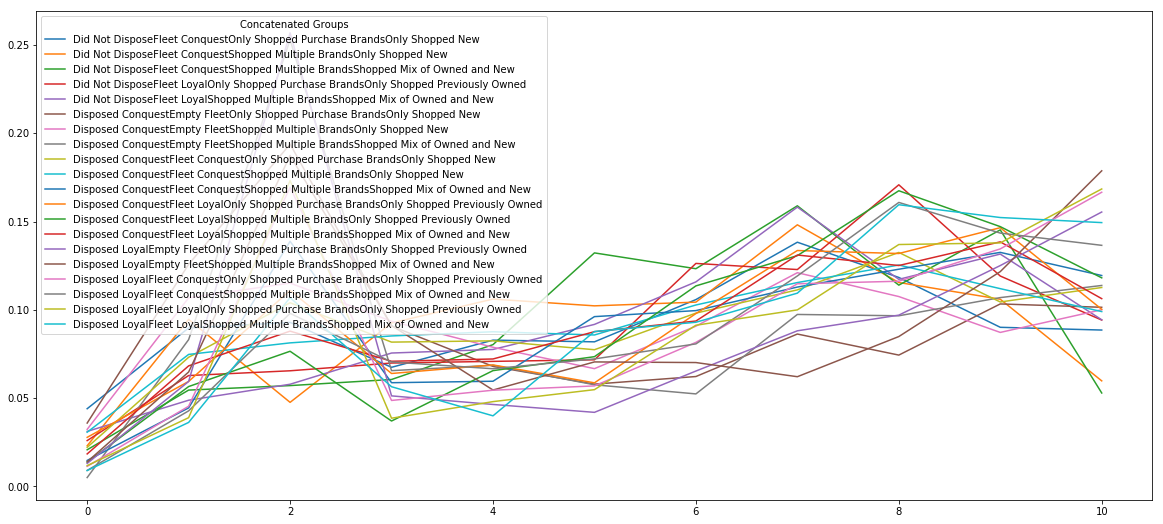

In [27]:
a = dfWorking.groupby(['Concatenated Groups','Age Bucket'])['Sales Weighting'].sum().unstack().fillna(0.0).drop(' ', axis=1).T
catByAge = a/a.sum()
catByAge.index=cols
catByAge.plot(kind='line', figsize=(20,9))

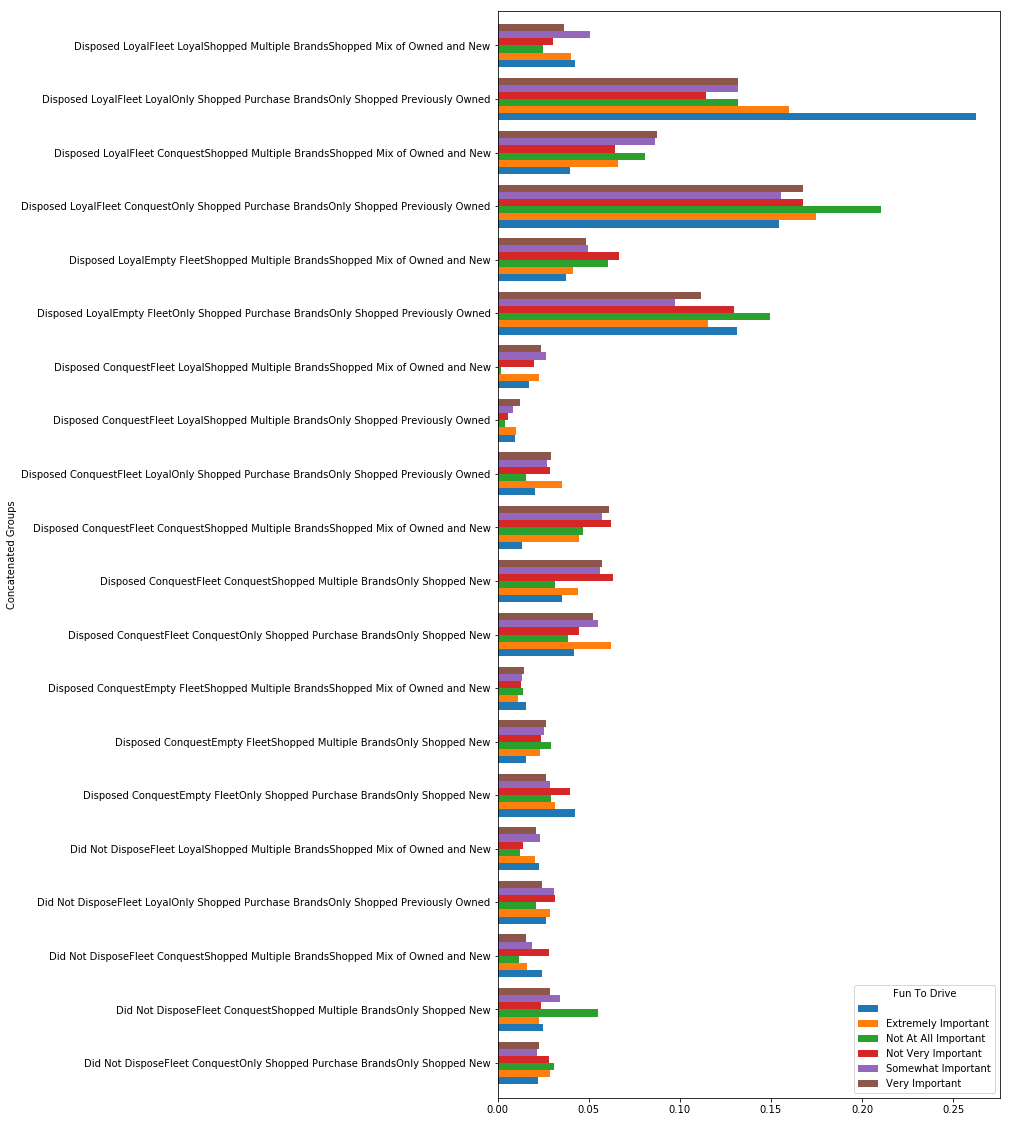

In [28]:
a = dfWorking.groupby(['Concatenated Groups','Fun To Drive'])['Sales Weighting'].sum().unstack().fillna(0.0)
catByIncome = a/a.sum()
catByIncome.plot(kind='barh', figsize=(9,20), width=0.8)

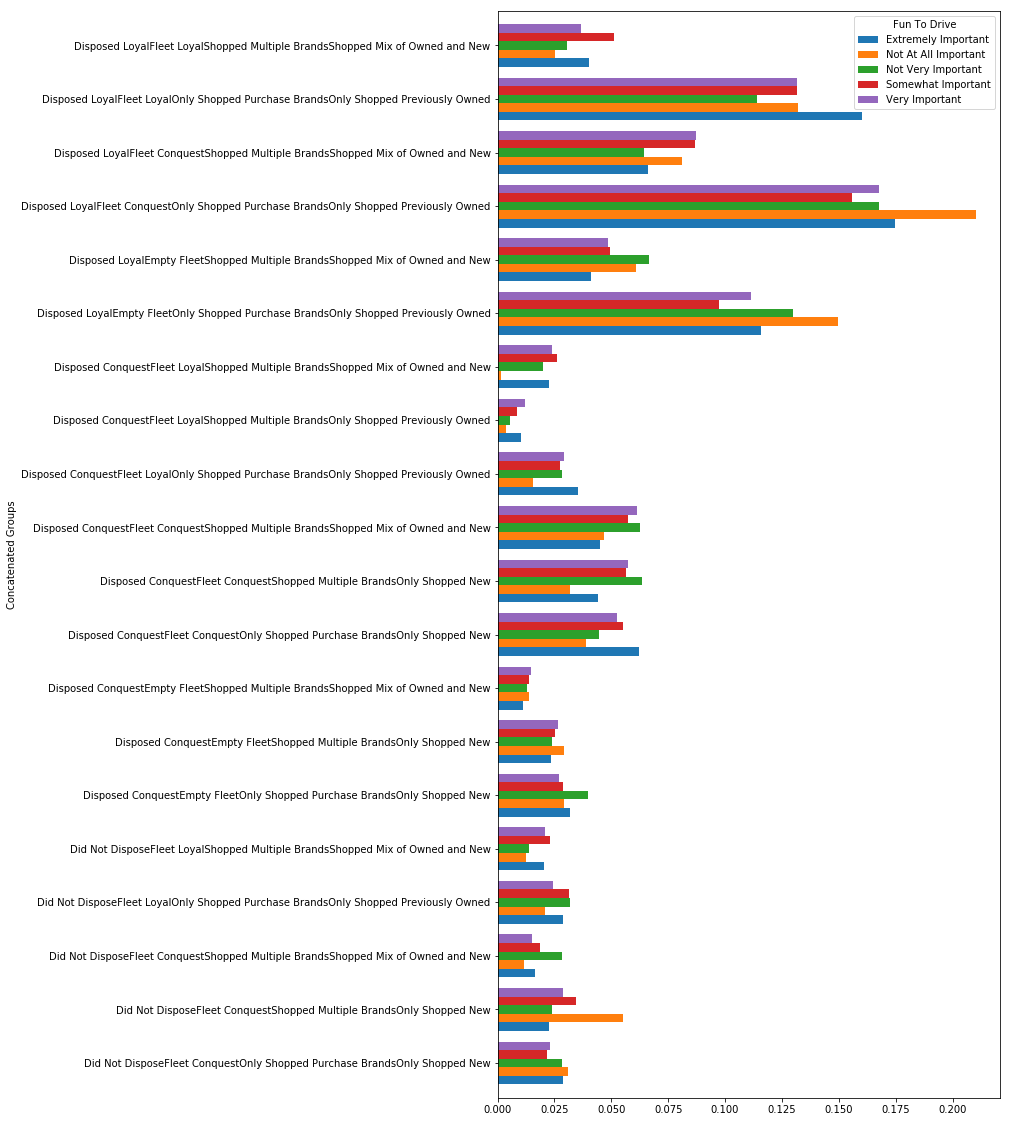

In [29]:
a = dfWorking.groupby(['Concatenated Groups','Fun To Drive'])['Sales Weighting'].sum().unstack().fillna(0.0)
catByIncome = a/a.sum()
catByIncome.drop(' ',axis=1).plot(kind='barh', figsize=(9,20), width=0.8)

In [30]:
#pd.DataFrame(dfWorking.columns).to_excel('working cols2.xlsx')

In [31]:
dfDistanceCols = pd.read_excel('working cols.xlsx')

In [32]:
a = dfDistanceCols[dfDistanceCols['Status']=='keep']
cols = list(a['Column'])
numericCols = a[a['type']=='Numeric']['Column']
dfDistance = dfWorking[cols]
dfDistance = dfDistance[~dfDistance['New Model Segment'].isin(['Full-Size Pickup', 'Heavy Duty Pickup','Luxury Multi-Function','Luxury Utility','Luxury Car','Full-Size Passenger Van'])]

In [33]:
#a = dfDistanceCols[dfDistanceCols['Status']=='keep']
#cols = list(a['Column'])
#numericCols = a[a['type']=='Numeric']['Column']
#dfDistance = dfWorking[cols]
#dfDistance = dfDistance[dfDistance['New Model Segment'].isin(['Full-Size Pickup', 'Heavy Duty Pickup'])]

In [34]:
dfDistance['New Model Segment'].unique()

array(['Mid-Size Car', 'Near Luxury', 'Small Car', 'Premium Coupe',
       'Large Car', 'Small Multi-Function', 'Premium Convertible/Roadster',
       'Mid-Size Multi-Function', 'Entry Utility', 'Mid-Specialty',
       'Mid-Size Crossover Utility', 'Mid-Size Traditional Utility',
       'Large Utility', 'Compact Pickup', 'Near Luxury Utility'], dtype=object)

In [35]:
for c in numericCols:
    print(c)
    dfDistance[c] = pd.to_numeric(dfDistance[c].replace(' ',np.nan))

Miles Driven Per Month on Average
Mpg - City
Mpg - Highway
Total Children In Household
Children Under 6
Children 6 To 12
Children 13 To 17
People 18 or Older
Total In Household
Purchase Price (100's)
Model Price Z score
Segment Price Z score


In [36]:
b = dfDistance.groupby('Concatenated Groups')['Sales Weighting'].sum()#.unstack().fillna(0.0)
(b/b.sum()).sort_values()

Concatenated Groups
Disposed ConquestFleet LoyalShopped Multiple BrandsOnly Shopped Previously Owned         0.009753
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New          0.013444
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New         0.016884
Did Not DisposeFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New            0.021435
Disposed ConquestFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New          0.024406
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned      0.026037
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New                0.026733
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New                      0.027685
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New                     0.028044
Disposed ConquestFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned    0.031332


In [37]:
def groupedWeightedAvg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [38]:
list(dfDistance.columns)

['ID',
 'Sales Weighting',
 'New Model Purchased (Alpha Order)',
 'New Model Purchased - Brand',
 'New Model - Corporation',
 'New Model Purchased - Region Origin',
 'New Model Segment',
 'Miles Driven Per Month on Average',
 'Mpg - City',
 'Mpg - Highway',
 'Gender',
 'Marital Status',
 'Lifestage',
 'Lifestage Variable (1)',
 'Lifestage Variable (2)',
 'Lifestage Plus Affluence (1)',
 'Lifestage Plus Affluence (2)',
 'Socioeconomic Groups (8)',
 'Age Bucket',
 'Total Children In Household',
 'Children Under 6',
 'Children 6 To 12',
 'Children 13 To 17',
 'People 18 or Older',
 'Total In Household',
 'Education',
 'Employment FT/PT/Self',
 'Occupation',
 'Total Family Pre-Tax Income',
 'Economic Outlook',
 'Ethnic Group (1)',
 'Location Of Residence',
 'Customer Region Classification',
 'State',
 'Research - Any Other Online/Internet Searches',
 'Research - AutoTrader.com',
 'Research - Car and Driver',
 'Research - Car Shows',
 'Research - CarGurus',
 'Research - CarMax',
 'Research 

In [39]:
dfResults = pd.DataFrame(dfDistance.groupby('Concatenated Groups')['Sales Weighting'].sum())
dfResults.columns=['Overall']
dfResults = dfResults.T
dfResults['Count'] = dfDistance['ID'].count()
dfResults = dfResults.T
#start loop at brand column, do not include ID and Sales Weight
for c in dfDistance.drop('Concatenated Groups',axis=1).columns[2:]:
    print(c)
    if is_numeric_dtype(dfDistance[c]):
        b = pd.DataFrame(dfDistance.groupby('Concatenated Groups').apply(groupedWeightedAvg,c,'Sales Weighting'))
        b.columns=[c]
        count = dfDistance[c].dropna().count()
        b=b.T
        b['Count']= count
        b=b.T
        dfResults = pd.concat([dfResults,b], axis=1)
    else:
        a = dfDistance.groupby(['Concatenated Groups',c])['Sales Weighting'].sum().unstack().fillna(0.0)
        counter = pd.DataFrame(dfDistance.groupby(['Concatenated Groups',c])['ID'].count().unstack().sum())
        counter.columns=['Count']
        counter=counter.T
        #drop rows that did not respond
        if ' ' in list(a.columns):
            a=a.drop(' ', axis=1)
            counter = counter.drop(' ', axis=1)
        if '' in list(a.columns):
            a=a.drop(' ', axis=1)
            counter = counter.drop('', axis=1)
        #calculate percentages for each unstacked value
        b = a
        b = pd.concat([counter,b], axis=0)
        #prepend column name to column values in unstacked frame
        name = b.columns.name
        newCols = []
        for d in b.columns:
            newCols.append(name+'_'+d)
        b.columns=newCols

        dfResults = pd.concat([dfResults,b], axis=1)

New Model Purchased (Alpha Order)
New Model Purchased - Brand
New Model - Corporation
New Model Purchased - Region Origin
New Model Segment
Miles Driven Per Month on Average
Mpg - City
Mpg - Highway
Gender
Marital Status
Lifestage
Lifestage Variable (1)
Lifestage Variable (2)
Lifestage Plus Affluence (1)
Lifestage Plus Affluence (2)
Socioeconomic Groups (8)
Age Bucket
Total Children In Household
Children Under 6
Children 6 To 12
Children 13 To 17
People 18 or Older
Total In Household
Education
Employment FT/PT/Self
Occupation
Total Family Pre-Tax Income
Economic Outlook
Ethnic Group (1)
Location Of Residence
Customer Region Classification
State
Research - Any Other Online/Internet Searches
Research - AutoTrader.com
Research - Car and Driver
Research - Car Shows
Research - CarGurus
Research - CarMax
Research - Cars.com
Research - Consumer Reports
Research - Costco Auto
Research - Dealership Websites
Research - Edmunds
Research - Events such as Ride and Drive
Research - Friends and Famil

In [40]:
percentages = dfResults.divide(dfResults['Overall'], axis='index')
percentages = percentages.drop('Count')
means = percentages.mean()
stDev = percentages.std()
sigmaDeltas = ((percentages-means)/stDev).drop('Overall', axis=1)
a = dfDistance.groupby('Concatenated Groups')['Sales Weighting'].sum()
a/a.sum()
sd = pd.concat([(a/a.sum()),pd.concat([pd.DataFrame(dfResults.drop('Overall', axis=1).loc['Count',:]).T,sigmaDeltas])], axis=1).sort_values('Sales Weighting', ascending=False)
sd = sd[list(numericCols)+[i for i in list(sd.columns) if i not in list(numericCols)]]
sd.to_excel('sigma deltas.xlsx')

In [41]:
(dfDistance.groupby(['New Model Purchased - Brand','Concatenated Groups'])['Sales Weighting'].sum().unstack()).divide(dfDistance.groupby(['Concatenated Groups'])['Sales Weighting'].sum(), axis=1).to_excel('Brand Breakdown by column.xlsx')

In [42]:
percentages

,Overall,New Model Purchased (Alpha Order)_Buick Enclave,New Model Purchased (Alpha Order)_Buick Encore,New Model Purchased (Alpha Order)_Buick LaCrosse,New Model Purchased (Alpha Order)_Buick Regal,New Model Purchased (Alpha Order)_Buick Verano,New Model Purchased (Alpha Order)_Chevrolet Colorado,New Model Purchased (Alpha Order)_Chevrolet Corvette Conv,New Model Purchased (Alpha Order)_Chevrolet Corvette Coupe,New Model Purchased (Alpha Order)_Chevrolet Cruze,...,Segment (Disposed)_SUV,Segment (Disposed)_Small Pickup,Segment (Disposed)_Smaller Car,Segment (Disposed)_Sporty Car,Segment (Disposed)_Unspecified Car,Segment (Disposed)_Unspecified Truck,Model Age (Disposed)_0-6 yo,Model Age (Disposed)_5-7 yo,Model Age (Disposed)_7+,Model Age (Disposed)_Did Not Dispose
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,1.0,0.003775,0.007606,0.002735,0.002286,0.000408,0.005640,0.002836,0.006176,0.012988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New,1.0,0.004199,0.006767,0.002607,0.002179,0.001944,0.011649,0.000983,0.005887,0.004422,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,1.0,0.005977,0.011240,0.002165,0.002068,0.001938,0.001488,0.000408,0.003009,0.008813,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned,1.0,0.001292,0.000521,0.002808,0.001006,0.000419,0.007722,0.001324,0.016585,0.015241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet LoyalShopped Multiple BrandsShopped Mix of Owned and New,1.0,0.000000,0.002530,0.000568,0.000815,0.002544,0.012896,0.000000,0.000593,0.006942,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,1.0,0.004065,0.015152,0.002945,0.001319,0.004942,0.006074,0.000208,0.000384,0.005994,...,0.233194,0.023019,0.410663,0.038472,0.015373,0.010513,0.351418,0.086520,0.545864,0.0
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New,1.0,0.004253,0.009303,0.000880,0.002838,0.003545,0.009985,0.000000,0.000000,0.005375,...,0.253712,0.016645,0.412960,0.044232,0.000984,0.001406,0.290018,0.110755,0.586689,0.0
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New,1.0,0.006256,0.014116,0.005438,0.003896,0.006490,0.003739,0.000513,0.000000,0.014758,...,0.288111,0.029281,0.406275,0.037672,0.006499,0.000719,0.389201,0.112247,0.495783,0.0
Disposed ConquestFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,1.0,0.009279,0.014473,0.003686,0.002952,0.004463,0.013416,0.000613,0.003164,0.003972,...,0.310802,0.017139,0.336933,0.041439,0.003244,0.002431,0.411700,0.120294,0.460756,0.0
Disposed ConquestFleet ConquestShopped Multiple BrandsOnly Shopped New,1.0,0.011520,0.008223,0.001192,0.002392,0.003628,0.008852,0.000674,0.001243,0.000000,...,0.315788,0.023099,0.300707,0.043953,0.002107,0.004031,0.309330,0.112642,0.569805,0.0


In [43]:
percentages.mean()

Overall                                                        1.000000
New Model Purchased (Alpha Order)_Buick Enclave                0.004676
New Model Purchased (Alpha Order)_Buick Encore                 0.008122
New Model Purchased (Alpha Order)_Buick LaCrosse               0.002358
New Model Purchased (Alpha Order)_Buick Regal                  0.001717
New Model Purchased (Alpha Order)_Buick Verano                 0.002516
New Model Purchased (Alpha Order)_Chevrolet Colorado           0.009488
New Model Purchased (Alpha Order)_Chevrolet Corvette Conv      0.000505
New Model Purchased (Alpha Order)_Chevrolet Corvette Coupe     0.002727
New Model Purchased (Alpha Order)_Chevrolet Cruze              0.008749
New Model Purchased (Alpha Order)_Chevrolet Equinox            0.018890
New Model Purchased (Alpha Order)_Chevrolet Impala             0.004421
New Model Purchased (Alpha Order)_Chevrolet Malibu             0.015914
New Model Purchased (Alpha Order)_Chevrolet SS                 0

In [44]:
var = 'New Model Segment'
for i in dfDistance[var].unique():
    dfResults = pd.DataFrame(dfDistance[dfDistance[var]==i].groupby('Concatenated Groups')['Sales Weighting'].sum())
    dfResults.columns=['Overall']
    dfResults = dfResults.T
    dfResults['Count'] = dfDistance[dfDistance[var]==i]['ID'].count()
    dfResults = dfResults.T
    print(i)
    #start loop at brand column, do not include ID and Sales Weight
    for c in dfDistance.drop('Concatenated Groups',axis=1).columns[2:]:
        
        if is_numeric_dtype(dfDistance[dfDistance[var]==i][c]):
            b = pd.DataFrame(dfDistance[dfDistance[var]==i].groupby('Concatenated Groups').apply(groupedWeightedAvg,c,'Sales Weighting'))
            b.columns=[c]
            count = dfDistance[dfDistance[var]==i][c].dropna().count()
            b=b.T
            b['Count']= count
            b=b.T
            dfResults = pd.concat([dfResults,b], axis=1)
        else:
            a = dfDistance[dfDistance[var]==i].groupby(['Concatenated Groups',c])['Sales Weighting'].sum().unstack().fillna(0.0)
            counter = pd.DataFrame(dfDistance[dfDistance[var]==i].groupby(['Concatenated Groups',c])['ID'].count().unstack().sum())
            counter.columns=['Count']
            counter=counter.T
            #drop rows that did not respond
            if ' ' in list(a.columns):
                a=a.drop(' ', axis=1)
                counter = counter.drop(' ', axis=1)
            if '' in list(a.columns):
                a=a.drop(' ', axis=1)
                counter = counter.drop('', axis=1)
            #calculate percentages for each unstacked value
            b = a
            b = pd.concat([counter,b], axis=0)
            #prepend column name to column values in unstacked frame
            name = b.columns.name
            newCols = []
            for d in b.columns:
                newCols.append(name+'_'+d)
            b.columns=newCols

            dfResults = pd.concat([dfResults,b], axis=1)
            
    percentages = dfResults.divide(dfResults['Overall'], axis='index')
    percentages = percentages.drop('Count')
    means = percentages.mean()
    stDev = percentages.std()
    sigmaDeltas = ((percentages-means)/stDev).drop('Overall', axis=1)
    a = dfDistance[dfDistance[var]==i].groupby('Concatenated Groups')['Sales Weighting'].sum()
    a/a.sum()
    sd = pd.concat([(a/a.sum()),pd.concat([pd.DataFrame(dfResults.drop('Overall', axis=1).loc['Count',:]).T,sigmaDeltas])], axis=1).sort_values('Sales Weighting', ascending=False)
    sd = sd[list(numericCols)+[i for i in list(sd.columns) if i not in list(numericCols)]]
    sd.T.to_excel('sigma deltas '+i.replace('/','_')+'.xlsx')

Mid-Size Car
Near Luxury
Small Car
Premium Coupe
Large Car
Small Multi-Function
Premium Convertible/Roadster
Mid-Size Multi-Function
Entry Utility
Mid-Specialty
Mid-Size Crossover Utility
Mid-Size Traditional Utility
Large Utility
Compact Pickup
Near Luxury Utility


In [45]:
percentages['How Likely to Recommend Own Vehicle Brand_10 - Extremely Likely']

Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New                0.833333
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New                     0.285714
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New         0.500000
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned      1.000000
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New                 0.375000
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New                      0.714286
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New          0.200000
Disposed ConquestFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New              0.612903
Disposed ConquestFleet ConquestShopped Multiple BrandsOnly Shopped New                   0.457143
Disposed ConquestFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New       0.400000
Disposed ConquestFle

In [46]:
dfMain = df[df['Main Survey Version']=='Main Study (Paper)']

In [47]:
df.groupby(['New Model Purchased - Brand','Disposed Loyal Conquest Other'])['Sales Weighting'].sum().unstack().divide(df.groupby(['New Model Purchased - Brand'])['Sales Weighting'].sum(), axis=0).loc[['Chevrolet','Ford','Honda','Hyundai','Nissan','Subaru','Toyota','Volkswagen']]

Disposed Loyal Conquest Other,Did Not Dispose,Disposed Conquest,Disposed Loyal,First Purchase
New Model Purchased - Brand,,,,
Chevrolet,0.110931,0.245914,0.622102,0.021053
Ford,0.100543,0.222415,0.654902,0.022139
Honda,0.133587,0.207187,0.604045,0.055181
Hyundai,0.115986,0.322973,0.518782,0.042258
Nissan,0.115755,0.264240,0.583000,0.037005
Subaru,0.088925,0.253843,0.636191,0.021041
Toyota,0.111468,0.208260,0.645253,0.035018
Volkswagen,0.174738,0.374309,0.380730,0.070223


In [48]:
dfMain.groupby(['New Model Purchased - Brand','Disposed Loyal Conquest Other'])['Sales Weighting'].sum().unstack().divide(dfMain.groupby(['New Model Purchased - Brand'])['Sales Weighting'].sum(), axis=0).loc[['Chevrolet','Ford','Honda','Hyundai','Nissan','Subaru','Toyota','Volkswagen']]

Disposed Loyal Conquest Other,Did Not Dispose,Disposed Conquest,Disposed Loyal,First Purchase
New Model Purchased - Brand,,,,
Chevrolet,0.105406,0.228584,0.643630,0.022379
Ford,0.102728,0.196826,0.675037,0.025410
Honda,0.121369,0.266923,0.587943,0.023765
Hyundai,0.077154,0.274686,0.606405,0.041755
Nissan,0.110709,0.247447,0.625832,0.016012
Subaru,0.075330,0.253468,0.654044,0.017158
Toyota,0.088840,0.189156,0.706505,0.015498
Volkswagen,0.186022,0.394134,0.371025,0.048819


In [49]:
percentages

,Overall,New Model Purchased (Alpha Order)_Buick Enclave,New Model Purchased - Brand_Buick,New Model - Corporation_General Motors Company,New Model Purchased - Region Origin_Domestic,New Model Segment_Near Luxury Utility,Miles Driven Per Month on Average,Mpg - City,Mpg - Highway,Gender_Female,...,Segment (Disposed)_SUV,Segment (Disposed)_Small Pickup,Segment (Disposed)_Smaller Car,Segment (Disposed)_Sporty Car,Segment (Disposed)_Unspecified Car,Segment (Disposed)_Unspecified Truck,Model Age (Disposed)_0-6 yo,Model Age (Disposed)_5-7 yo,Model Age (Disposed)_7+,Model Age (Disposed)_Did Not Dispose
Did Not DisposeFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,82.572295,2.096066,3.175857,0.500000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet ConquestShopped Multiple BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,121.330719,1.493301,2.006623,0.571429,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,1.0,1.0,1.0,1.0,1.0,1.0,273.123745,2.985306,2.350135,0.500000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Did Not DisposeFleet LoyalOnly Shopped Purchase BrandsOnly Shopped Previously Owned,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Disposed ConquestEmpty FleetOnly Shopped Purchase BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,164.350625,3.429926,4.215951,0.625000,...,0.375000,0.000000,0.000000,0.125,0.000000,0.000000,0.625000,0.000000,0.375000,0.0
Disposed ConquestEmpty FleetShopped Multiple BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,583.320765,3.173265,2.799940,0.142857,...,0.571429,0.000000,0.000000,0.000,0.000000,0.000000,0.428571,0.285714,0.285714,0.0
Disposed ConquestEmpty FleetShopped Multiple BrandsShopped Mix of Owned and New,1.0,1.0,1.0,1.0,1.0,1.0,181.100098,3.201264,3.384194,0.800000,...,0.800000,0.000000,0.200000,0.000,0.000000,0.000000,0.200000,0.200000,0.600000,0.0
Disposed ConquestFleet ConquestOnly Shopped Purchase BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,33.192833,0.459227,0.544886,0.387097,...,0.709677,0.000000,0.032258,0.000,0.032258,0.000000,0.419355,0.129032,0.451613,0.0
Disposed ConquestFleet ConquestShopped Multiple BrandsOnly Shopped New,1.0,1.0,1.0,1.0,1.0,1.0,22.399517,0.375192,0.391992,0.485714,...,0.628571,0.028571,0.057143,0.000,0.000000,0.000000,0.400000,0.228571,0.371429,0.0
Disposed ConquestFleet ConquestShopped Multiple BrandsShopped Mix of Owned and New,1.0,1.0,1.0,1.0,1.0,1.0,43.945928,0.454465,0.547359,0.425000,...,0.600000,0.000000,0.100000,0.000,0.000000,0.000000,0.525000,0.150000,0.325000,0.0


In [50]:
#get model sales percentages
#get disposed loyalty percentages
#calculate sales percentage weights
#weighted sales percentage = (model n)*(model weight)/(total weight)
#model weight = (sales percentage)*(total weight)/(model n)
#need to chose decent total weight? total sales count? what is a good minimum model weight?
#using sales weights, calculate diposed loyalty weights
#(model disposed loyalty percentage) = (model weighted n)*(model loyalty weight)/(total weight)
#recalculate sales weights using (sales+loyalty) model weights
#recalculate loyalty weights
#loop until convergence
#need test for convergence. average weight delta from last iteration? check for bimodality/nonconvergence/divergence?
#test with two models first, check for convergence/divergence and make sure weighting algo works